In [ ]:
!pip install kaggle pandas transformers torch scikit-learn
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the MovieLens dataset
!kaggle datasets download -d grouplens/movielens-20m-dataset
!unzip movielens-20m-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
100% 195M/195M [00:00<00:00, 211MB/s]
100% 195M/195M [00:00<00:00, 211MB/s]
Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 



# **1. Data Cleaning**


We will begin with data cleaning such that we can handle missing values, outliers, rare values and drop the unnecessary features that do not carry useful information.



In [ ]:

# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())

No. of duplicates records in the dataset :  0


Observations:



*   There are no duplicate records in the dataset.



## **1.1 Handling Missing Values**


Identifying the features that have some missing values and imputing them.



In [ ]:

# Checking the columns' titles and datatypes

movie_ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5072 entries, 0 to 5071
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   5072 non-null   int64  
 1   movieId  184 non-null    float64
 2   rating   5072 non-null   float64
 3   date     0 non-null      float64
 4   title    184 non-null    object 
 5   genres   184 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 237.9+ KB


Observations:


*   It looks like that the dataset is well maintained as we do not see any missing values, which is good.



# **1.2 Exploratory Data Analysis**
**bold text**

After the data cleaning steps, we can now perform EDA on the dataset to discover patterns and relationships that will help in understanding the data better.




## **1.2.1 Univariate Analysis**

Analyzing each feature inidividually to gain insights from the data and discover any outliers.



In [ ]:

# Checking the number of missing values in data

movie_ratings.isna().sum()

,0
userId,0
movieId,4888
rating,0
date,5072
title,4888
genres,4888


In [ ]:
# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  50
The top 5 userID in the dataset are : 
 userId
24    506
11    504
7     276
31    246
14    243
Name: count, dtype: int64


In [ ]:
# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts().head(5))

The count of unique movieID in the dataset is :  75
The top 5 movieID in the dataset are : 
 movieId
919.0    14
631.0    14
126.0    12
567.0     8
977.0     7
Name: count, dtype: int64


Observations:



*   "movieId" represents the movies with at least one rating or tag in the dataset.

*  There are close to 26K+ unique movies in the dataset.

*   movieId 294, 353, 316 and 588 are few popular movies which has been rated over 60K times.


In [ ]:
# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"


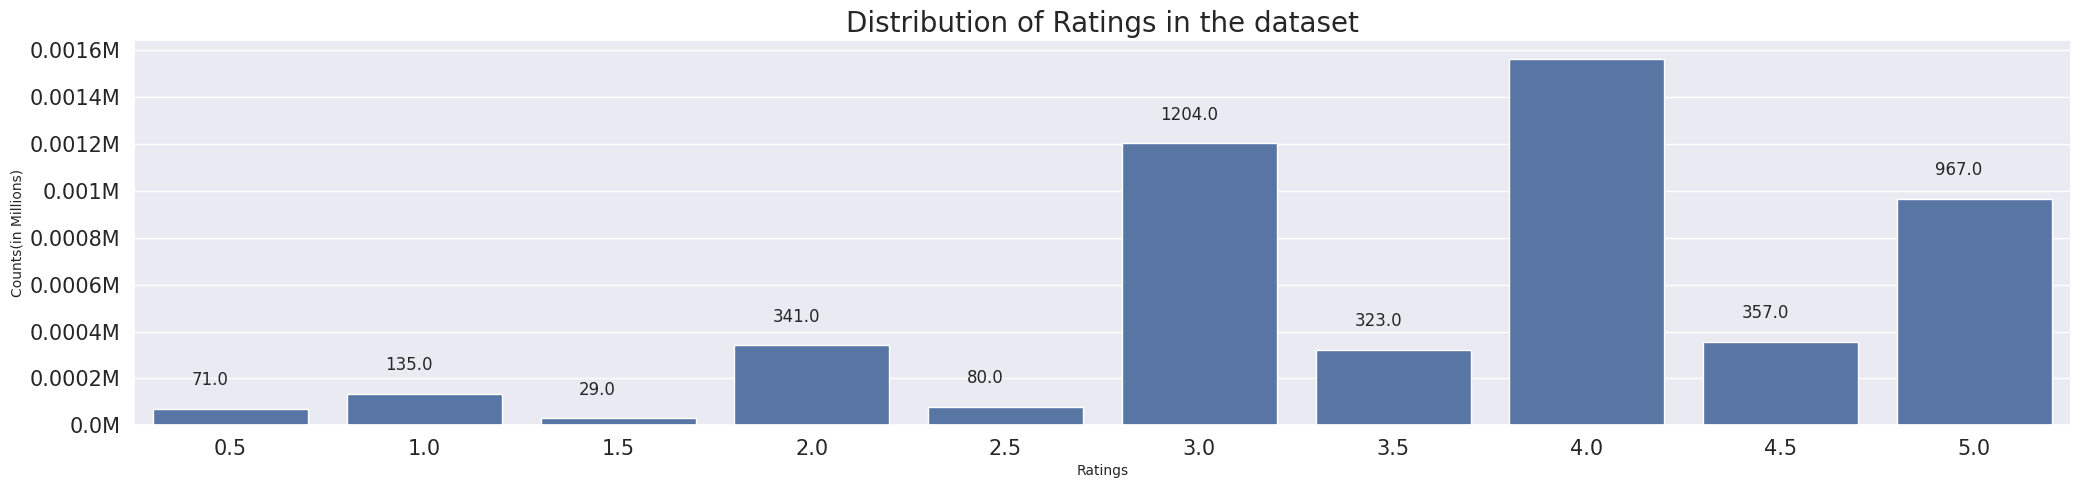

In [ ]:
# Checking the feature "rating"

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 5), sharey=True)


sns.countplot(x="rating", data=movie_ratings)  # Removed 'ax=axes'
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in the dataset", fontsize = 20)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Counts(in Millions)", fontsize = 10)
plt.show()

Observations:



*   The ratings given by users to movies lies in between 0.5 to 5.

*   A high proportion of the movies have been rated 3, 3.5 or 4 by the users.

*   The distribution of ratings look a bit left skewed as large proportion of ratings is in between 3 to 5.







In [ ]:

# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  0
The first rating was given on :  nan
The latest rating was given on :  nan
The top 5 date in the dataset are : 
 Series([], Name: count, dtype: int64)


Observations:



* There are ~7K unique dates when the ratings were given by a user to a movie.

* The first rating was given on 1995-01-09 and the latest rating was given on 2015-03-31.

* Around 91K+ ratings were observed on 2000-11-20.



In [ ]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  74
The top 5 title in the dataset are : 
 title
Shrek (2001)                                                 14
Titanic (1997)                                               14
Interview with the Vampire: The Vampire Chronicles (1994)    12
Clear and Present Danger (1994)                               8
Apocalypse Now (1979)                                         7
Name: count, dtype: int64


Observations:



* There are 26K+ unique movie titles in the dataset.

* Pulp Fiction, Forrest Gump, Shawshank Redemption and Silence of the Lambs are the top 4 movies in terms of no. of ratings received which are over 60K+ for each one.



In [ ]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    # Check if x is a string before applying split
    if isinstance(x, str):
        for g in x.split("|"):
            if g not in unique_genres.keys():
                unique_genres[g] = 1
            else:
                unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")


Genres Extracted from the dataset.


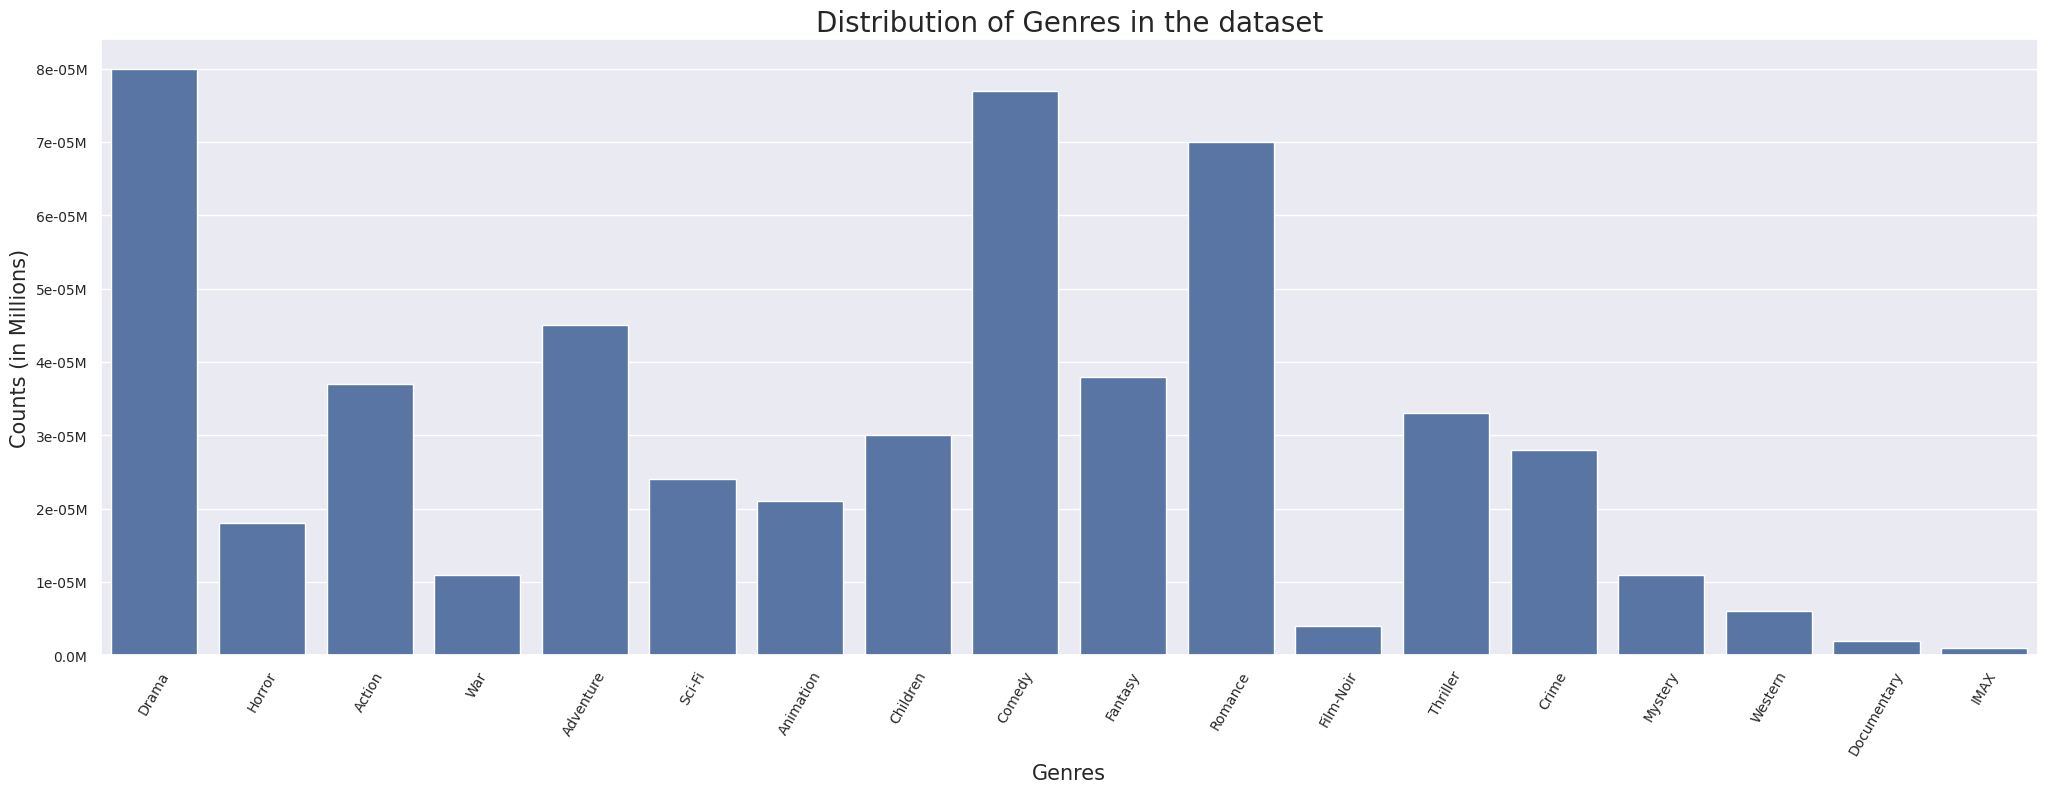

In [ ]:

# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()


Observations:



*   There are 19 different genres of movies while there are few whose genre has not been mentioned.

*   Drama, Comedy, Action and Thriller are top 4 genres of movies present in the dataset.


